In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.model_selection import KFold
import pickle

from notebooks.imports import *
from config import dir_config
from src.utils import pmf_utils, glm_hmm_utils

In [3]:
compiled_dir = Path(dir_config.data.compiled)
processed_dir = Path(dir_config.data.processed)

In [41]:
_TRIALS = "all_trials"
# _TRIALS = "all_trials_eq_prior"

data_path = f"glm_hmm_{_TRIALS}_final.pkl"
if "eq_prior" in _TRIALS:
    eq_only = True
else:
    eq_only = False

n_trial_back = 1

state_prob_threshold = 0.8

In [5]:
with open(Path(processed_dir, data_path), "rb") as f:
    glm_hmm = pickle.load(f)
models = glm_hmm["model"]["models"]
data = glm_hmm["data"]

session_metadata = pd.read_csv(Path(processed_dir, "sessions_metadata.csv"))

## Distribution of number of switches

In [6]:
def calculate_posterior_prob(model, data):
    if "no_bias" in _TRIALS:
        input = np.array(
            data[
                ["normalized_stimulus"] +
                [f"prev_choice_{t+1}" for t in range(n_trial_back)] +
                [f"prev_target_{t+1}" for t in range(n_trial_back)]
            ]
        )
    else:
        input = np.array(
            data[
                ["normalized_stimulus", "bias"] +
                [f"prev_choice_{t+1}" for t in range(n_trial_back)] +
                [f"prev_target_{t+1}" for t in range(n_trial_back)]
            ]
        )
    return model.expected_states(data=data["choices"].values.reshape(-1, 1), input=input, mask=np.array(data["mask"].values.reshape(-1, 1)))[0]

In [7]:
def get_switch_number(posterior_prob):
    state_1_trials = posterior_prob[:,0] > state_prob_threshold
    state_2_trials = posterior_prob[:,1] > state_prob_threshold
    trial_states = np.full(posterior_prob.shape[0], np.nan)
    # return state_1_trials, state_2_trials, trial_states
    trial_states[state_1_trials] = 1
    trial_states[state_2_trials] = 2

    # ignore nan(transitioning) trials
    high_confidence_state_mask = ~np.isnan(trial_states)
    state_diff = np.diff(trial_states[high_confidence_state_mask])
    switch_time = np.where(high_confidence_state_mask)[0][np.where(state_diff)[0]+1]
    return switch_time

In [42]:
posterior_probs = {}
relative_switch_times = {}
switch_stats = {"relative_times":{}, "num_of_switches":[]}
pre_switch_trials = 500
post_switch_trials = 900
biased_relative_posterior_prob = np.full((pre_switch_trials+post_switch_trials,len(session_metadata)),np.nan)
unbiased_relative_posterior_prob = np.full((pre_switch_trials+post_switch_trials,len(session_metadata)),np.nan)

for session_idx, session in enumerate(session_metadata["session_id"]):
    model = models[session]
    session_data = data[session]
    prob_toRF = session_data["prob_toRF"][session_data["mask"]]
    indices = np.where((prob_toRF != 50) & ~np.isnan(prob_toRF))[0]
    block_switch = indices[0] if len(indices) > 0 else 0
    posterior_probs[session] = calculate_posterior_prob(model, session_data)
    switch_times= get_switch_number(posterior_probs[session])
    switch_stats["relative_times"][session] = switch_times - block_switch
    switch_stats["num_of_switches"].append(len(switch_times))
    if posterior_probs[session].shape[0] < block_switch+post_switch_trials:
        if block_switch-pre_switch_trials < 0:
            biased_relative_posterior_prob[pre_switch_trials-block_switch:posterior_probs[session].shape[0]-block_switch+pre_switch_trials, session_idx] = posterior_probs[session][:, 0]
            unbiased_relative_posterior_prob[pre_switch_trials-block_switch:posterior_probs[session].shape[0]-block_switch+pre_switch_trials, session_idx] = posterior_probs[session][:, 1]
        else:
            biased_relative_posterior_prob[:posterior_probs[session].shape[0]-block_switch+pre_switch_trials, session_idx] = posterior_probs[session][block_switch-pre_switch_trials: , 0]
            unbiased_relative_posterior_prob[:posterior_probs[session].shape[0]-block_switch+pre_switch_trials, session_idx] = posterior_probs[session][block_switch-pre_switch_trials: , 1]
    else:
        if block_switch-pre_switch_trials < 0:
            biased_relative_posterior_prob[pre_switch_trials-block_switch:, session_idx] = posterior_probs[session][:block_switch+post_switch_trials, 0]
            unbiased_relative_posterior_prob[pre_switch_trials-block_switch:, session_idx] = posterior_probs[session][:block_switch+post_switch_trials, 1]
        else:
            biased_relative_posterior_prob[:,session_idx] = posterior_probs[session][block_switch-pre_switch_trials: block_switch+post_switch_trials, 0]
            unbiased_relative_posterior_prob[:,session_idx] = posterior_probs[session][block_switch-pre_switch_trials: block_switch+post_switch_trials, 1]


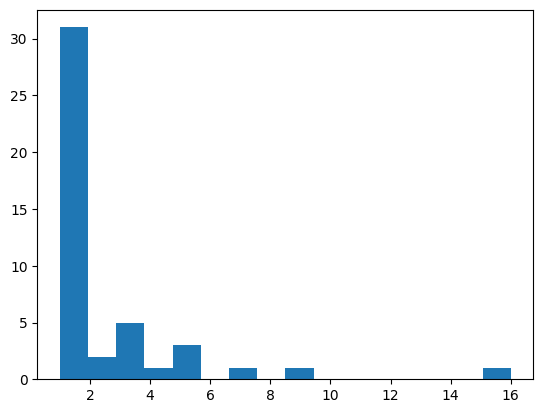

In [9]:
plt.figure()
plt.hist(switch_stats["num_of_switches"], bins=16)
plt.show()

## Time course of switch

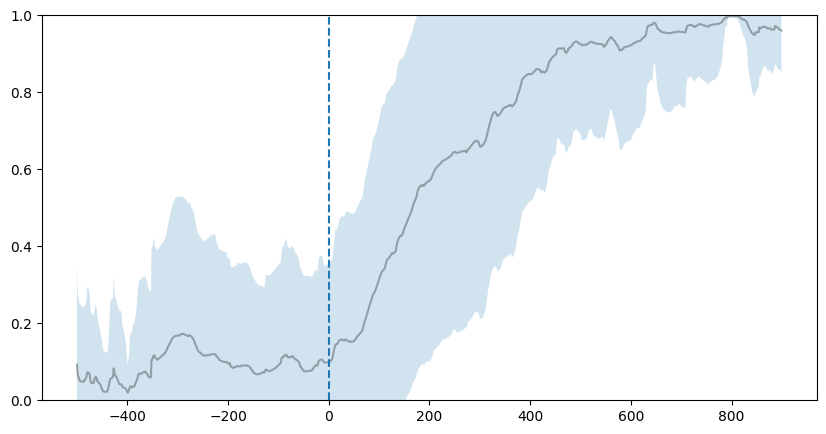

In [ ]:
plt.figure(figsize=(10, 5))
high_conf_prob_in_biased_state = biased_relative_posterior_prob / (biased_relative_posterior_prob + unbiased_relative_posterior_prob)
plt.plot(np.arange(-pre_switch_trials, post_switch_trials), np.nanmean(high_conf_prob_in_biased_state, axis=1), color='k', alpha=0.3)
plt.fill_between(np.arange(-pre_switch_trials, post_switch_trials),
                 np.nanmean(high_conf_prob_in_biased_state, axis=1) - np.nanstd(high_conf_prob_in_biased_state, axis=1),
                 np.nanmean(high_conf_prob_in_biased_state, axis=1) + np.nanstd(high_conf_prob_in_biased_state, axis=1),
                 alpha=0.2)
plt.ylim([0, 1])
plt.vlines(0, 0, 1, linestyles='dashed')
plt.show()


## Distribution of time to switch

Text(0.5, 1.0, 'Distribution of GLM-HMM state switches relative to block switches')

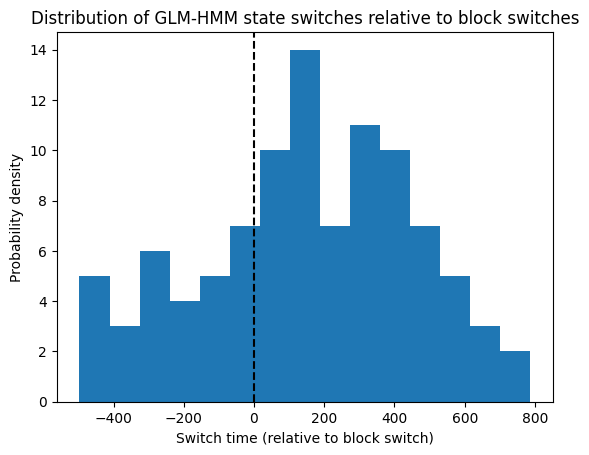

In [50]:
test_switch_times = np.concatenate(list(switch_stats['relative_times'].values()))
plt.hist(test_switch_times, bins=15)
plt.axvline(0, color='k', linestyle='--')

plt.xlabel("Switch time (relative to block switch)")
plt.ylabel("Probability density")
plt.title("Distribution of GLM-HMM state switches relative to block switches")

## Distribution of transition probs

In [63]:
transition_prob_arr = []
for session_idx, session in enumerate(session_metadata["session_id"]):
    model = models[session]
    model_transitions = np.exp(model.transitions.params)[0]
    transition_prob_arr.append(model_transitions)
transition_prob_arr = np.array(transition_prob_arr)

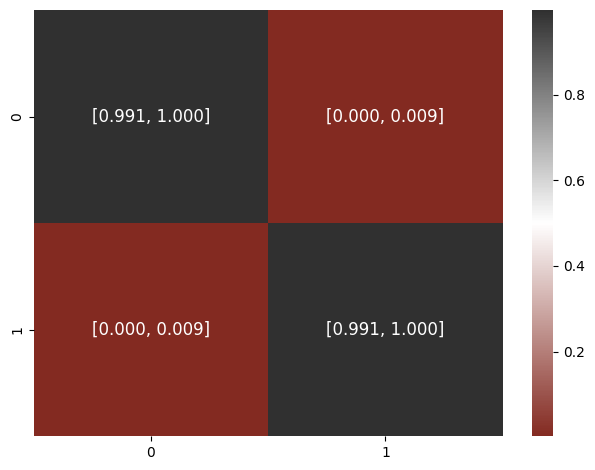

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Example heatmap data
transition_prob_mean = np.round(np.mean(transition_prob_arr, axis=0), decimals=3)
transition_prob_std = np.round(np.std(transition_prob_arr, axis=0), decimals=3)

# Define lower and upper bounds, clipped between 0 and 1
lower_bound = np.clip(transition_prob_mean - transition_prob_std, 0, 1)
upper_bound = np.clip(transition_prob_mean + transition_prob_std, 0, 1)

# Plot
plt.figure()
sns.heatmap(transition_prob_mean, cmap=custom_cmap, alpha=1)

# Add text annotations with capped range
for i in range(transition_prob_arr.shape[1]):
    for j in range(transition_prob_arr.shape[2]):
        lb = lower_bound[i, j]
        ub = upper_bound[i, j]
        plt.text(j + 0.5, i + 0.5, f"[{lb:.3f}, {ub:.3f}]",
                 ha="center", va="center", color="white", fontsize=12)

plt.tight_layout()
plt.show()
